In [214]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random
import math
import warnings
warnings.filterwarnings("ignore")

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

np.random.seed(0)
random.seed(0)

In [215]:
def delta_schedule(n):
    ### Definition : 
    # Δₙ : la marge de confiance nécessaire pour inférer un label sans l’oracle.
    # Dans A², Δₙ contrôle la confiance dans la comparaison des erreurs empiriques.

        # Si : |err_pos - err_neg| > Δₙ 
        #    alors l’algorithme considère que l’un des deux labels est très probablement correct.
        # Si la différence est trop faible, 
        #    alors il existe trop d’ambiguïté → requête à l’oracle.

    ### Fonction : 
    # Δₙ = sq_rt ( 1 / n) * 𝛿(n)
    # où δ(n) est une fonction décroissante 
    # ( d'habitude : 1 / sq_rt(n), c / sq_rt(n), sq_rt((log(n)) / n )
    # ici :  c / sq_rt(n) avec c = 0.1
        
    ### Interpretation:
    # Lorsque n est petit → Δₙ est grand 
    #   → l’algorithme préfère poser des questions à l’oracle.
    # Lorsque n augmente → Δₙ diminue 
    #   → l’algorithme devient plus confiant et infère plus de labels.
    
    return 0.1 / math.sqrt(n)


In [216]:
def prepare_data_for_A2(X, y, test_size=0.3, stream_seed=1):
    """
    OUTPUT : 
    X_stream : flux pour l’apprentissage actif (Données arrivant séquentiellement pour A²)
    X_pool : données candidates pour le flux (stream), utilisées pour l’apprentissage actif.
    X_test : données finales utilisées uniquement pour évaluer le classifieur appris.
    y_pool, y_test : labels correspondants.
    X_pool_arr, y_pool_arr : copies utiles pour des comparaisons externes.
    oracle : fonction simulant les "questions au professeur" (Donne le vrai label quand A² ne peut pas décider)


                    Données globales X
                             │
                             ▼
                      ┌────────────┐
                      │   X_pool   │  ← données candidates
                      └────────────┘
                            │
               ┌────────────┴─────────────┐
               ▼                          ▼
           X_stream                       X_test
      (flux pour A²)                    (jamais vu)

            A² lit X_stream 1 par 1 :
            - soit il infère             → ajoute à S
            - soit il demande à l’oracle → ajoute à T

    """

    ### STEP 0 :  Verifie données sont en bonnes format
    y = np.array(y)

    ### STEP 1 : Séparation pool/test 
    # Dans l’apprentissage actif, il n’y a pas de X_train au départ.
    # Le modèle construit progressivement son ensemble d’entraînement en choisissant des points dans X_pool
    # (stratify=y garantit que les proportions des classes sont respectées)
    X_pool, X_test, y_pool, y_test = train_test_split( X, y, test_size=test_size, random_state=42, stratify=y    )

    ### STEP 2 : Construction du flux de données (stream)
    # le flux dans lequel A² voit les points un par un
    rng = np.random.RandomState(stream_seed)
    indices = np.arange(len(X_pool))
    rng.shuffle(indices)                # mélange les indices
    X_stream = X_pool[indices]          # flux final (les données du pool dans un ordre aléatoire)

    ### STEP 3 : Conversion des labels du pool en {-1, +1}
    y_pool_mapped = np.where(y_pool == 0, -1, 1) # traduit les labels initiaux ( 0 1) en labels conformes à la théorie (-1 +1)

    ### STEP 4 : Copies utiles des tableaux (pour comparaisons)
    X_pool_arr = np.array(X_pool)
    y_pool_arr = np.array(y_pool)

    ### STEP 5 : 
    # L’oracle doit fournir le vrai label d’un point du flux lorsque A² le demande.
    # Pour cela, on crée une table de correspondance :
    #   clé : un point (transformé en tuple pour être hashable)  
    #   valeur : son label {−1, +1}

    pool_map = {tuple(x): label for x, label in zip(X_pool, y_pool_mapped)}

    def oracle(x):
        # Si A² ne peut pas décider entre +1 et −1 pour un point, il interroge l’oracle.
        # L’oracle retourne le vrai label à partir du dictionnaire pool_map.
        ## Le +1 par défaut est un choix de sécurité (mais rarement utilisé, car tous les points du flux appartiennent au pool)
        return pool_map.get(tuple(x), +1)

    return {
        "X_stream": X_stream,
        "X_test": X_test,
        "y_test": y_test,
        "X_pool_arr": X_pool_arr,
        "y_pool_arr": y_pool_arr,
        "oracle": oracle
    }

In [217]:
def plot_accuracy_vs_queries(X_stream, X_test, y_test, oracle, learner):
    accuracies = []
    queries = []
    S, T = [], []

    y_test_mapped = np.where(y_test == 0, -1, 1)

    for n, x_n in enumerate(X_stream, start=1):
        h_pos = learner.learn_H(S + [(x_n, +1)], T)
        h_neg = learner.learn_H(S + [(x_n, -1)], T)
        err_pos = learner.empirical_error(h_pos, S + T)
        err_neg = learner.empirical_error(h_neg, S + T)
        Delta = learner.delta_schedule(max(1, n - 1))

        inferred_label = None
        if err_neg - err_pos > Delta:
            inferred_label = +1
        elif err_pos - err_neg > Delta:
            inferred_label = -1

        if inferred_label is not None:
            S.append((x_n, inferred_label))
        else:
            y_n = oracle(x_n)
            T.append((x_n, y_n))

        # recalculer précision toutes les 10 requêtes
        if n % 10 == 0:
            h_final = learner.learn_H(S, T)
            preds = h_final.predict(X_test)
            acc = np.mean(preds == y_test_mapped)
            accuracies.append(acc)
            queries.append(len(T))

    plt.figure(figsize=(6,4))
    plt.plot(queries, accuracies, marker='o')
    plt.xlabel("Nombre de requêtes à l'oracle")
    plt.ylabel("Précision sur X_test")
    plt.title("Évolution de la précision vs nombre de requêtes")
    plt.grid(True)
    plt.show()


In [218]:
def plot_results(res, dataset_name):
    labels = ["A² Active", "Passive baseline"] + list(res["passive_classifiers"].keys())
    accs = [res["acc_active"], res["acc_passive"]] + list(res["passive_classifiers"].values())
    
    plt.figure(figsize=(7,4))
    plt.bar(labels, accs, color='skyblue')
    plt.ylabel("Test Accuracy")
    plt.title(f"{dataset_name} — Test Accuracy Comparison")
    plt.xticks(rotation=30)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

In [219]:
class A2ActiveLearner:
    """
    Données Internes:
    S : (x, y_hat)  ensemble des points étiquetés implicitement (labels inférés par l’algorithme ie ensemble des labels inférés, utilisés comme si l’oracle avait répondu).
    T : (x, y_true) ensemble des points étiquetés explicitement (requêtes au véritable oracle ie ensemble des labels réellement demandés à l’oracle).
    n_requetes_oracle : nombre total de requêtes à l’oracle.

    Données Externes:
    delta_schedule : Δₙ (fonction)  la marge de confiance nécessaire pour inférer un label sans l’oracle.
    learn_H :
    """
    
    def __init__(self, learn_H, delta_schedule):
        ## Données internes : 
        self.S = []
        self.T = []
        self.n_requetes_oracle = 0

        self.learn_H = learn_H
        self.delta_schedule = delta_schedule

    @staticmethod
    def empirical_error(h, dataset):
        if len(dataset) == 0:
            return 0.0
        X = np.array([x for (x, y) in dataset])
        y = np.array([y for (x, y) in dataset])
        preds = h.predict(X)
        return np.mean(preds != y)

    def algorithmA2(self, X_stream, oracle, verbose = False):
        self.S = []
        self.T = []
        n_infered = 0  # compteur labels inférés
        self.n_requetes_oracle = 0

        for n, x_n in enumerate(X_stream, start=1):
            ## STEP 1 : Calcul des deux hypothèses candidates
            # “Train h⁺ and h⁻ using candidate labels +1 and -1”

            # Pour chaque point x_n, vous construisez deux hypothèses :
            #   h_pos = hypothèse entraînée sur S ∪ T avec (x_n, +1) ajouté dans S,
            #   h_neg = hypothèse entraînée sur S ∪ T avec (x_n, −1) ajouté dans S.

            #h_pos = self.learn_H(self.S + [(x_n, +1)], self.T)
            #h_neg = self.learn_H(self.S + [(x_n, -1)], self.T)

            ## Création des hypothèses candidate
            #       ça ajout a S (x_n, y_hat) PUIS apprenant un classifieur
            h_learn_pos = self.S + [(x_n, +1)]
            h_learn_neg = self.S + [(x_n, -1)]
            
            h_pos = self.learn_H(h_learn_pos, self.T)
            h_neg = self.learn_H(h_learn_neg, self.T)


            ## STEP 2 : Erreurs empiriques associées
            # definition des "versions spaces" restreints ( ou en anglais : version space disagreement )
            err_pos = self.empirical_error(h_pos, self.S + self.T)
            err_neg = self.empirical_error(h_neg, self.S + self.T)

            ## STEP 3 : Calcul du seuil Delta Δₙ
            Delta = self.delta_schedule(max(1, n - 1))

            ## STEP 4 :  Décision d’inférence
            # “Infer the label if the difference in empirical errors exceeds the threshold; otherwise query.”
            inferred_label = None

            # Si err_neg - err_pos > Δ ⇒ label inféré = +1
            if err_neg - err_pos > Delta:
                inferred_label = +1

            # Si err_pos - err_neg > Δ ⇒ label inféré = −1
            elif err_pos - err_neg > Delta:
                inferred_label = -1

            # Sinon ⇒ requête à l’oracle

            ## STEP 5 : Mise à jour (inférence ou requête)
            # Si le label est inféré, ajout dans S
            if inferred_label is not None:
                self.S.append((x_n, inferred_label))
                n_infered += 1

            # Sinon → interrogation de l'oracle et ajout dans T
            else:
                y_n = oracle(x_n)
                self.T.append((x_n, y_n))
                self.n_requetes_oracle += 1

            #  Affichage tous les 50 points
            if verbose and n % 50 == 0:  # affichage tous les 50 points
                print(f"Point {n}: inférés {n_infered}, oracle {self.n_requetes_oracle}")


            ## STEP 6 : Construction de l’hypothèse finale
            # apprenez un dernier classifieur h_final basé sur S ∪ T
        h_final = self.learn_H(self.S, self.T)
        return h_final, self.n_requetes_oracle



In [220]:
## AVANT ON AVAIT CA MAIS JE TROUVAIS DIFFICILE A EXPLIQUER
#
#def learn_H_fn(S, T):
#    """
#    Gére les 3 cas (garantit que l’algorithme A² ne plante jamais):
#        Pas de données	    Retourne un modèle qui prédit +1 pour tout
#        Une seule classe	Retourne un modèle constant qui prédit ce label
#        Deux classes	    Entraîne une logistic regression normale
#    
#    """
#    ### STEP 1 : Fusion des données S et T (des listes de tuples (x, y)) pour avoir S ∪ T
#    data = S + T
#
#    ### STEP 2 : 
#
#    ## Cas 1 : aucune donnée disponible
#    # On ne peut pas entraîner un classifieur sans données, 
#    # donc on renvoie donc un classifieur trivial qui prédit toujours +1.
#    if len(data) == 0:
#        class ConstantPred:
#            def predict(self, X):
#                X = np.asarray(X)
#                return np.ones(len(X), dtype=int)
#        return ConstantPred()
#    
#    # Extraction de X, y
#    X = np.array([x for (x, y) in data])
#    y = np.array([y for (x, y) in data])
#
#    # Conversion des labels dans le format scikit-learn
#    y_sklearn = np.where(y == -1, 0, 1)
#
#    ## Cas 2 : une seule classe présente
#    # La régression logistique ne peut pas s’entraîner avec une seule classe.
#    # Donc si toutes les données portent le même label, 
#    # on retourne un classifieur constant qui prédit ce label.
#    unique = np.unique(y_sklearn)
#    
#    if len(unique) == 1:
#        cls = unique[0]
#        mapped_output = -1 if cls == 0 else 1
#        class ConstantPredClass:
#            def __init__(self, mapped_output):
#                self.mapped_output = mapped_output
#            def predict(self, X):
#                X = np.asarray(X)
#                return np.full(len(X), self.mapped_output, dtype=int)
#        return ConstantPredClass(mapped_output)
#    
#    ## Cas 3 : les deux classes sont présentes → apprentissage normal
#    clf = LogisticRegression(max_iter=100, solver='liblinear')
#    clf.fit(X, y_sklearn)
#
#    ### STEP 3 : Wrapper pour remapper les labels
#    class SklearnWrapper:
#        def __init__(self, clf):
#            self.clf = clf
#        def predict(self, X):
#            X = np.asarray(X)
#            preds = self.clf.predict(X)
#            return np.where(preds == 0, -1, 1) # # traduit les labels initiaux ( 0 1) en labels conformes à la théorie (-1 +1)
#    return SklearnWrapper(clf)
#

In [221]:
## IDEM : AVANT ON AVAIT CA MAIS JE TROUVAIS DIFFICILE A EXPLIQUER
#
#def run_passive_baseline(X_pool, y_pool, n_queries, learn_H):
#    if n_queries == 0:
#        class ConstantPred:
#            def predict(self, X):
#                X = np.asarray(X)
#                return np.ones(len(X), dtype=int)
#        return ConstantPred()
#    idx = np.random.choice(len(X_pool), size=n_queries, replace=False)
#    X_train = X_pool[idx]
#    y_train = y_pool[idx]
#    y_train_mapped = np.where(y_train == 0, -1, 1)
#    data = list(zip(X_train, y_train_mapped))
#    clf = learn_H(data, [])
#    return clf

In [222]:
import numpy as np
from sklearn.linear_model import LogisticRegression

class SimpleClassifier:
    """
    Un classifieur générique pouvant fonctionner en :
    - mode constant (toujours prédire y = +1 ou -1),
    - mode logistic regression binaire normal.

    Gére les 3 cas (garantit que l’algorithme A² ne plante jamais): 
        - Pas de données    Retourne un modèle qui prédit +1 pour tout 
        - Une seule classe  Retourne un modèle constant qui prédit ce label 
        - Deux classes      Entraîne une logistic regression normale
    """
    def __init__(self, mode="constant", constant_value=1, clf=None):
        self.mode = mode                            # "constant" ou "logreg"
        self.constant_value = constant_value        # utilisé en mode constant
        self.clf = clf                              # logistic regression entraînée

    def predict(self, X):
        X = np.asarray(X)

        if self.mode == "constant":
            return np.full(len(X), self.constant_value, dtype=int)

        # Sinon => logistic regression
        preds = self.clf.predict(X)
        return np.where(preds == 0, -1, 1)


In [223]:
def learn_H_fn(S, T):
    """
    Gère les 3 cas :
        - S ∪ T = ∅
        - une seule classe
        - deux classes → logistic regression
    """
    
    ### STEP 1 : Fusion des données S et T (des listes de tuples (x, y)) pour avoir S ∪ T
    data = S + T

    ### STEP 2 : ## Cas 1 : aucune donnée disponible 
    # On ne peut pas entraîner un classifieur sans données, 
    # donc on renvoie donc un classifieur trivial qui prédit toujours +1.

    if len(data) == 0:
        return SimpleClassifier(mode="constant", constant_value=1)

    # Extraction X et y
    X = np.array([x for (x, y) in data])
    y = np.array([y for (x, y) in data])

    # Conversion des labels dans le format scikit-learn
    y_sklearn = np.where(y == -1, 0, 1)

    ## Cas 2 : une seule classe présente 
    # La régression logistique ne peut pas s’entraîner avec une seule classe. 
    # Donc si toutes les données portent le même label, 
    # on retourne un classifieur constant qui prédit ce label.
    unique = np.unique(y_sklearn)
    
    if len(unique) == 1:
        const_value = -1 if unique[0] == 0 else 1
        return SimpleClassifier(mode="constant", constant_value=const_value)

    ## Cas 3 : les deux classes sont présentes → apprentissage normal
    clf = LogisticRegression(max_iter=200, solver="liblinear")
    clf.fit(X, y_sklearn)

    return SimpleClassifier(mode="logreg", clf=clf)


In [224]:
def run_passive(X_pool, y_pool, n_queries, clf_class, **clf_kwargs):
    """Entraîne un classifieur passif choisi sur n_queries exemples du pool"""
    idx = np.random.choice(len(X_pool), size=n_queries, replace=False)
    X_train, y_train = X_pool[idx], y_pool[idx]
    y_train = np.where(y_train == 0, -1, y_train)
    
    clf = clf_class(**clf_kwargs)
    clf.fit(X_train, y_train)
    return clf

In [225]:
def run_passive_baseline(X_pool, y_pool, n_queries, learn_H):
    """
    Entraîne un modèle passif sur n_queries exemples tirés au hasard.
    Si n_queries = 0 → retourne un classifieur constant +1.
    """
    # STEP 0 : aucune requête → modèle trivial
    if n_queries == 0:
        return SimpleClassifier(mode="constant", constant_value=1)

    # STEP 1 : Sélection aléatoire de n_queries données
    idx = np.random.choice(len(X_pool), size=n_queries, replace=False)
    X_train = X_pool[idx]
    y_train = y_pool[idx]

    # STEP 2 : Remapping 0 → -1 si nécessaire
    y_train = np.where(y_train == 0, -1, y_train)

    # STEP 3 : Format (x, y)
    data = list(zip(X_train, y_train))

    # STEP 4 : Entraînement via learn_H
    model = learn_H(data, [])

    return model


In [226]:
def run_experiment(X, y, test_size=0.3, stream_seed=1):
    
    data = prepare_data_for_A2(X, y, test_size, stream_seed)

    X_stream = data["X_stream"]
    X_test = data["X_test"]
    y_test = data["y_test"]
    X_pool_arr = data["X_pool_arr"]
    y_pool_arr = data["y_pool_arr"]
    oracle = data["oracle"]

    # Créez le learner
    active = A2ActiveLearner(learn_H_fn, delta_schedule)

    # Option 1 : tracer avant de lancer l'expérimentation finale
    plot_accuracy_vs_queries(X_stream, X_test, y_test, oracle, active)

    # Option 2 : lancer l'algorithme complet puis tracer
    h_active, n_requetes_oracle = active.algorithmA2(X_stream, oracle, True)
    
    h_passive = run_passive_baseline(X_pool_arr, y_pool_arr, n_requetes_oracle, learn_H_fn)

    y_test_mapped = np.where(y_test == 0, -1, 1)
    preds_active = h_active.predict(X_test)
    preds_passive = h_passive.predict(X_test)

    acc_active = accuracy_score(y_test_mapped, preds_active)
    acc_passive = accuracy_score(y_test_mapped, preds_passive)

        # Définition des classifieurs passifs à tester
    passive_classifiers = {
        "Naive Bayes": GaussianNB,
        "kNN": lambda: KNeighborsClassifier(n_neighbors=5),
        "Random Forest": lambda: RandomForestClassifier(n_estimators=100, random_state=0),
        "SVM": lambda: SVC(kernel='linear', C=1.0),
        "Logistic Regression": lambda: LogisticRegression(max_iter=200, solver='liblinear')
    }

    passive_results = {}
    for name, clf_fn in passive_classifiers.items():
        # Sélection aléatoire de n_queries points pour le passif
        idx = np.random.choice(len(X_pool_arr), size=n_requetes_oracle, replace=False)
        X_train = X_pool_arr[idx]
        y_train = y_pool_arr[idx]
        y_train_mapped = np.where(y_train == 0, -1, y_train)

        clf = clf_fn() if callable(clf_fn) else clf_fn
        clf.fit(X_train, y_train_mapped)
        preds = clf.predict(X_test)
        passive_results[name] = accuracy_score(y_test_mapped, preds)

    return {
        "acc_active": acc_active,
        "acc_passive": acc_passive,
        "queries": n_requetes_oracle,
        "n_pool": len(X_pool_arr),
        "n_test": len(X_test),
        "passive_classifiers": passive_results
    }

## Création de données synthétiques:

In [227]:
# Run experiments with reduced synthetic size for speed
X_syn, y_syn = make_classification(n_samples=600, n_features=20, n_informative=10,
                                   n_redundant=5, n_clusters_per_class=2, flip_y=0.05, random_state=0)


## Importation de dataset : breast cancer 

*(https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)*

In [228]:
bc = load_breast_cancer()
X_bc = bc.data
y_bc = bc.target

## Run les algos : A² et Passif

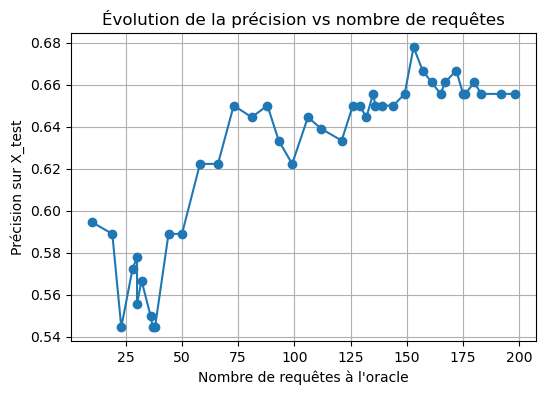

Point 50: inférés 20, oracle 30
Point 100: inférés 62, oracle 38
Point 150: inférés 77, oracle 73
Point 200: inférés 94, oracle 106
Point 250: inférés 118, oracle 132
Point 300: inférés 151, oracle 149
Point 350: inférés 183, oracle 167
Point 400: inférés 217, oracle 183


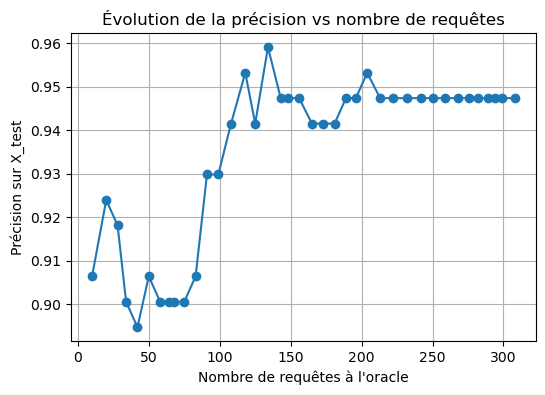

Point 50: inférés 8, oracle 42
Point 100: inférés 25, oracle 75
Point 150: inférés 32, oracle 118
Point 200: inférés 44, oracle 156
Point 250: inférés 54, oracle 196
Point 300: inférés 58, oracle 242
Point 350: inférés 68, oracle 282


Results summary:
     dataset  acc_active  acc_passive  queries
   Synthetic    0.655556     0.672222      198
BreastCancer    0.947368     0.941520      313

Dataset: Synthetic
A² Active Accuracy: 0.656
Passive baseline Accuracy: 0.672
Number of queries: 198
Other passive classifiers:
  Naive Bayes: 0.711
  kNN: 0.850
  Random Forest: 0.783
  SVM: 0.672
  Logistic Regression: 0.683

Dataset: BreastCancer
A² Active Accuracy: 0.947
Passive baseline Accuracy: 0.942
Number of queries: 313
Other passive classifiers:
  Naive Bayes: 0.942
  kNN: 0.918
  Random Forest: 0.942
  SVM: 0.947
  Logistic Regression: 0.942


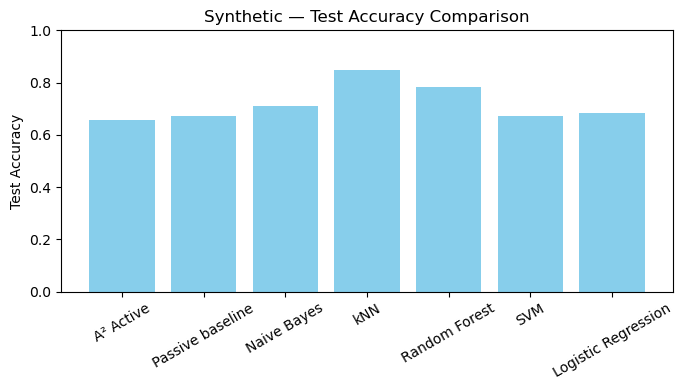

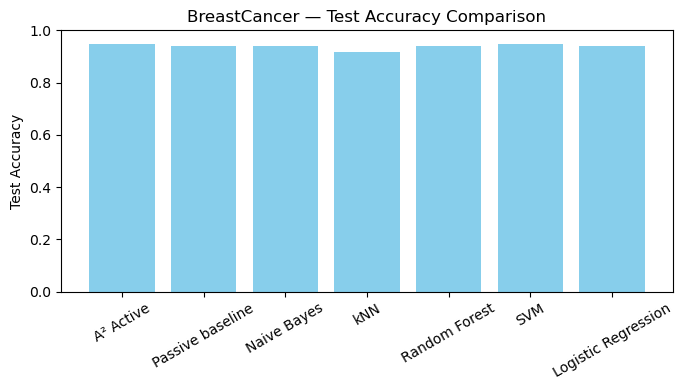

In [229]:
res_syn = run_experiment(X_syn, y_syn, test_size=0.3, stream_seed=2)

res_bc = run_experiment(X_bc, y_bc, test_size=0.3, stream_seed=3)


results_df = pd.DataFrame([
    {"dataset": "Synthetic", "acc_active": res_syn["acc_active"], "acc_passive": res_syn["acc_passive"], "queries": res_syn["queries"]},
    {"dataset": "BreastCancer", "acc_active": res_bc["acc_active"], "acc_passive": res_bc["acc_passive"], "queries": res_bc["queries"]},
])

print("\n\nResults summary:")
print(results_df.to_string(index=False))


for name, res in zip(["Synthetic", "BreastCancer"], [res_syn, res_bc]):
    print(f"\nDataset: {name}")
    print(f"A² Active Accuracy: {res['acc_active']:.3f}")
    print(f"Passive baseline Accuracy: {res['acc_passive']:.3f}")
    print(f"Number of queries: {res['queries']}")
    print("Other passive classifiers:")
    for clf_name, acc in res['passive_classifiers'].items():
        print(f"  {clf_name}: {acc:.3f}")

plot_results(res_syn, "Synthetic")
plot_results(res_bc, "BreastCancer")



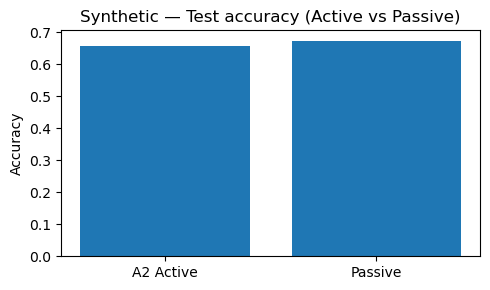

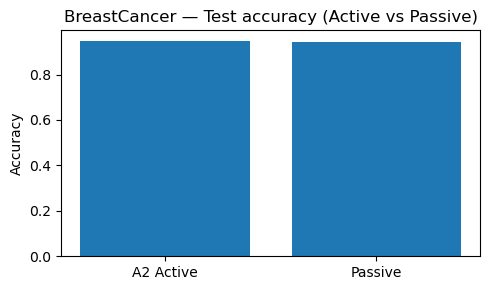

In [230]:
for i, row in results_df.iterrows():
    plt.figure(figsize=(5,3))
    plt.title(f"{row['dataset']} — Test accuracy (Active vs Passive)")
    plt.bar([0,1], [row['acc_active'], row['acc_passive']])
    plt.xticks([0,1], ['A2 Active', 'Passive'])
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.show()

try:
    from caas_jupyter_tools import display_dataframe_to_user
    display_dataframe_to_user("A2 vs Passive results", results_df)
except Exception:
    pass

#results_df.to_csv("/mnt/data/a2_vs_passive_results.csv", index=False)
#print("\nA CSV with the results was saved at /mnt/data/a2_vs_passive_results.csv")

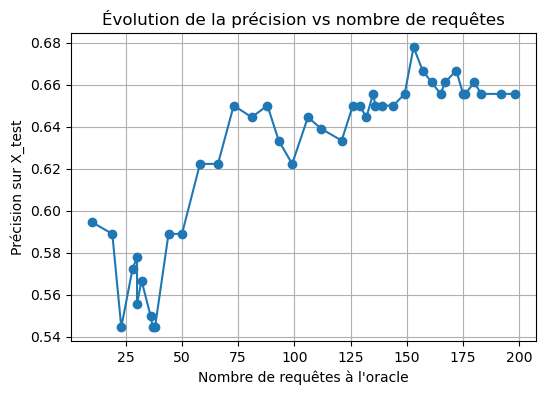

Point 50: inférés 20, oracle 30
Point 100: inférés 62, oracle 38
Point 150: inférés 77, oracle 73
Point 200: inférés 94, oracle 106
Point 250: inférés 118, oracle 132
Point 300: inférés 151, oracle 149
Point 350: inférés 183, oracle 167
Point 400: inférés 217, oracle 183


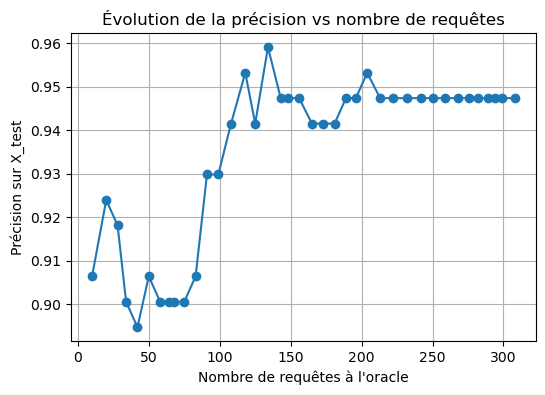

Point 50: inférés 8, oracle 42
Point 100: inférés 25, oracle 75
Point 150: inférés 32, oracle 118
Point 200: inférés 44, oracle 156
Point 250: inférés 54, oracle 196
Point 300: inférés 58, oracle 242
Point 350: inférés 68, oracle 282


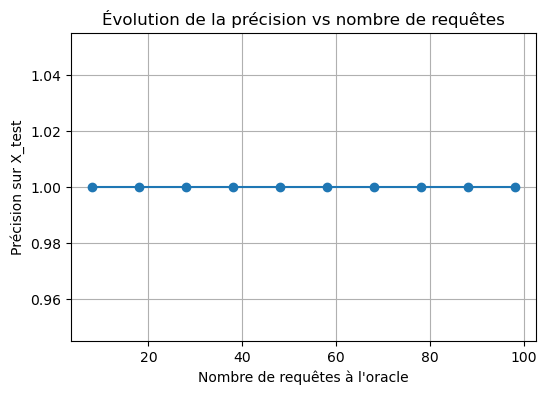

Point 50: inférés 2, oracle 48
Point 100: inférés 2, oracle 98


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [238]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification, load_breast_cancer
from sklearn.preprocessing import LabelEncoder

# Liste des datasets locaux (chemins relatifs vers les fichiers CSV)
uci_datasets = {
    "Iris": r"C:\Users\damoi\OneDrive - UMONS\Master2\Q1\AdvancML\Projet\data\iris.data.txt",
    "Wine": r"C:\Users\damoi\OneDrive - UMONS\Master2\Q1\AdvancML\Projet\data\wine.data.txt"
}

# Stockage des résultats
results_list = []

# Dataset synthétique
X_syn, y_syn = make_classification(
    n_samples=600, n_features=20, n_informative=10,
    n_redundant=5, n_clusters_per_class=2, flip_y=0.05, random_state=0
)
res_syn = run_experiment(X_syn, y_syn, test_size=0.3, stream_seed=2)
results_list.append(("Synthetic", res_syn))

# Dataset BreastCancer
bc = load_breast_cancer()
X_bc = bc.data
y_bc = bc.target
res_bc = run_experiment(X_bc, y_bc, test_size=0.3, stream_seed=3)
results_list.append(("BreastCancer", res_bc))

# Boucle sur les datasets UCI locaux
for name, path in uci_datasets.items():
    df = pd.read_csv(path, header=None)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    
    # Encoder les labels textuels si nécessaire
    if y.dtype == object:
        y = LabelEncoder().fit_transform(y)
    
    res = run_experiment(X, y, test_size=0.3, stream_seed=4)
    results_list.append((name, res))

# Créer un DataFrame récapitulatif
results_df = pd.DataFrame([
    {
        "dataset": name,
        "acc_active": res["acc_active"],
        "acc_passive": res["acc_passive"],
        "queries": res["queries"]
    }
    for name, res in results_list
])

print("\nResults summary:")
print(results_df.to_string(index=False))

# Affichage détaillé par dataset
for name, res in results_list:
    print(f"\nDataset: {name}")
    print(f"A² Active Accuracy: {res['acc_active']:.3f}")
    print(f"Passive baseline Accuracy: {res['acc_passive']:.3f}")
    print(f"Number of queries: {res['queries']}")
    print("Other passive classifiers:")
    for clf_name, acc in res['passive_classifiers'].items():
        print(f"  {clf_name}: {acc:.3f}")
